In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
%matplotlib
import matplotlib
matplotlib.rcParams["figure.figsize"] = (15,10)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly 
import plotly.express as ex
import seaborn as sns
from plotly.io import templates
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder


sns.set(style= 'whitegrid', color_codes=True)
sns.set_theme(context='notebook',style='darkgrid',
              palette='deep',font='sans-serif',font_scale=1,color_codes=True,rc=None)
%matplotlib inline

# Medical Cost Prediction
in this project I would like to build a app to predict the medical cost base on personal attributes(region,gender,age,bmi,smoke or not,the number of children) 

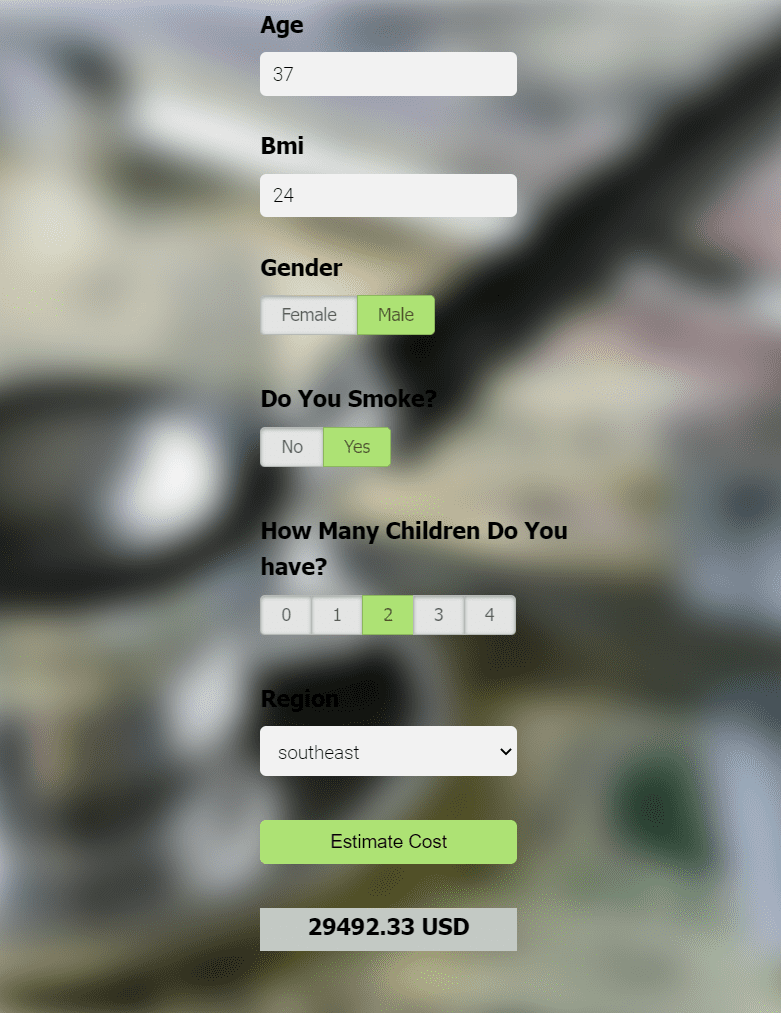

Link for the app: https://github.com/Eames07/Medical-Cost-Prediction-App

# Load data

In [ ]:
Expenditure = pd.read_csv("../input/medical-insurance-payout/expenses.csv")

In [ ]:
Expenditure.head(4)

In [ ]:
#Check the null value
Expenditure.isnull().sum()

In [ ]:
df=Expenditure

# EDA

In [ ]:
#Change categorical value into int
df['smoker']=Expenditure.smoker.map(dict(yes=1, no=0))
df['sex']=Expenditure.sex.map(dict(male=1, female=0))

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), vmin=-1, cmap="YlGnBu_r", annot=True)

In [ ]:
Children=Expenditure.children.value_counts().rename_axis('NumberofChildren').reset_index(name='count')

In [ ]:
plt.figure(figsize=(10,10))
colors = ['#FFF8DC', '#9BCD9B', '#66CDAA', '#20B2AA',"#009ACD","#104E8B"]

plt.pie(Children["count"].tolist(), labels=Children["NumberofChildren"].tolist(), labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors,
       autopct='%1.1f%%',shadow=True);
plt.title("Number of Children")

In [ ]:
region=Expenditure.region.value_counts().rename_axis('region').reset_index(name='count')

In [ ]:
plt.figure(figsize=(10,10))
colors = ['#FFF8DC', '#9BCD9B', '#66CDAA', '#20B2AA']

plt.pie(region["count"].tolist(), labels=region["region"].tolist(), labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors,
       autopct='%1.1f%%', shadow=True);
plt.title("Region Distribution")

In [ ]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
sns.distplot(Expenditure.age, kde = True, color='#0000FF', kde_kws={'color':'black'})
plt.show()

In [ ]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
sns.distplot(Expenditure.bmi, kde = True, color='#0000FF', kde_kws={'color':'black'})
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='smoker', data = Expenditure, palette='GnBu', saturation=0.8)

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='sex', data = Expenditure, palette='GnBu', saturation=0.8)

In [ ]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
sns.distplot(Expenditure.charges, kde = True, color='#0000FF', kde_kws={'color':'black'})
plt.show()

# Model Building

In [ ]:
#convert "region" in to dummies columns
dummies = pd.get_dummies(df.region)

In [ ]:
df1 = pd.concat([df.drop('region',axis='columns'),dummies],axis='columns')

In [ ]:
x=df1.drop(columns="charges")
y=df1.charges

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train,y_train)
LR.score(x_test,y_test)

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), x, y, cv=cv)

In [ ]:
#try to find the best model between decision, linear regression and lasso
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(x,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score'])

find_best_model_using_gridsearchcv(x,y)

In [ ]:
df1

In [ ]:
def predict_charges(region,age,sex,bmi,children,smoker):    
    reg_index  = np.where(x.columns==region)[0][0]

    a = np.zeros(len(x.columns))
    a[0] = age
    a[1] = sex
    a[2] = bmi
    a[3] = children
    a[4] = smoker
    if reg_index >= 0:
        a[reg_index] = 1

    return LR.predict([a])[0]

In [ ]:
#the medical cost prediction for person(age 23, female, bim 27, have 0 children, smoke) 
predict_charges('southwest',23, 0, 27, 0, 1)

In [ ]:
#the medical cost prediction for person(age 37, male, bim 35, have 2 children, do not smoke) 
predict_charges('southwest',37, 1, 35, 2, 0)

# Export the model

In [ ]:
import pickle
with open('MedicalExpenditure','wb') as f:
    pickle.dump(LR,f)

In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

# Code for the Flask Server

In [ ]:
#server.py


# from flask import Flask, request, jsonify
# import util
# app = Flask(__name__)


# @app.route('/get_region')
# def get_region():
#     response = jsonify({
#         'region':util.get_region()
#     })
#     response.headers.add('Access-Control-Allow-Origin','*')
#     return response

# @app.route('/predict_medical_charge',methods=['POST'])
# def predict_medical_charge():
#     age = int(request.form['age'])
#     sex = int(request.form['sex'])
#     bmi = int(request.form['bmi'])
#     children = int(request.form['children'])
#     smoker = int(request.form['smoker'])
#     region = request.form['region']

#     response = jsonify({
#         'estimated_price':util.get_estimatied_price(region,age,sex,bmi,children,smoker)
#     })
#     response.headers.add('Access-Control-Allow-Origin', '*')
#     return response
# if __name__ == "__main__":
#     print('Starting Python Flask Sever For Medical Cost Prediction')
#     util.load_save_artifacts()
#     app.run()

In [ ]:
#util.py

# import json
# import pickle
# import numpy as np
# __regions = None
# __data_columns = None
# __model = None

# def get_estimatied_price(region,age, sex, bmi, children, smoker):
#     try:
#         reg_index = __data_columns.index(region.lower())
#     except:
#         reg_index=-1

#     a = np.zeros(len(__data_columns))
#     a[0] = age
#     a[1] = sex
#     a[2] = bmi
#     a[3] = children
#     a[4] = smoker
#     if reg_index >= 0:
#         a[reg_index] = 1
#     return round(__model.predict([a])[0],2)

# def get_region():
#     return __regions

# def load_save_artifacts():
#     print("Loading save artifacts... start")
#     global __data_columns
#     global __regions

#     with open("./artifacts/columns.json",'r') as f:
#         __data_columns = json.load(f)['data_columns']
#         __regions = __data_columns[5:]

#     global __model
#     with open("./artifacts/MC.pickle",'rb') as f:
#         __model = pickle.load(f)
#         print("loading saved artifacts...done")


# if __name__ == '__main__':
#     load_save_artifacts()
#     print(get_region())
#     print(get_estimatied_price('southwest',26,1,27,3,1))
#     print(get_estimatied_price('southwest', 26, 1, 27, 3, 0))

# Code for the Client

In [ ]:
#app.js

# function getChildrenValue() {
#   var uiChildren = document.getElementsByName("uiChildren");
#   for(var i in uiChildren) {
#     if(uiChildren[i].checked) {
#         return parseInt(i);
#     }
#   }
#   return -1; // Invalid Value
# }

# function getSmokeValue() {
#   var uiSmoke = document.getElementsByName("uiSmoke");
#   for(var i in uiSmoke) {
#     if(uiSmoke[i].checked) {
#         return parseInt(i);
#     }
#   }
#   return -1; // Invalid Value
# }

# function getGenderValue() {
#   var uiGender = document.getElementsByName("uiGender");
#   for(var i in uiGender) {
#     if(uiGender[i].checked) {
#         return parseInt(i);
#     }
#   }
#   return -1; // Invalid Value
# }

# function onClickedEstimatePrice() {
#   console.log("Estimate price button clicked");
#  var age = document.getElementById("uiAge");
#   var bmi = document.getElementById("uiBmi");
#   var gender = getGenderValue();
#   var smoke = getSmokeValue();
#   var children = getChildrenValue();
#   var region = document.getElementById("uiRegion");
#   var estPrice = document.getElementById("uiEstimatedPrice");

#   var url = "http://127.0.0.1:5000/predict_medical_charge";
#   //var url = "/api/predict_medical_charge"

#   $.post(url, {
#       region: region.value,
#       age: age.value,
#       sex: gender,
#       bmi: bmi.value,
#       children: children,
#       smoker: smoke,
      
#   },function(data, status) {
#       console.log(data.estimated_price);
#       estPrice.innerHTML = "<h2>" + data.estimated_price.toString() + " USD</h2>";
#       console.log(status);
#   });
# }


# function onPageLoad() {
#   console.log( "document loaded" );
#   var url = "http://127.0.0.1:5000/get_region";
#   //var url = "/api/get_region"
#   $.get(url,function(data, status) {
#       console.log("got response for get_location_names request");
#       if(data) {
#           var region = data.region;
#           var uiRegion = document.getElementById("uiRegion");
#           $('#uiRegion').empty();
#           for(var i in region) {
#               var opt = new Option(region[i]);
#               $('#uiRegion').append(opt);
#           }
#       }
#   });
# }

# window.onload = onPageLoad;
  

In [ ]:
#app.HTML

# <!DOCTYPE html>
# <html>
# <head>
#     <title>Medical Cost Prediction</title>
#     <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.4.1/jquery.min.js"></script>
#     <script src="app.js"></script>
# 	<link rel="stylesheet" href="app.css">
# </head>
# <body>
# <div class="img"></div>
# <form class="form">
# 	<h2>Age</h2>
#     <input class="age"  type="text" id="uiAge" class="floatLabel" name="Age" value="21">

# 	<h2>Bmi</h2>
#     <input class="bmi"  type="text" id="uiBmi" class="floatLabel" name="Bmi" value="25">

# 	<h2>Gender</h2>
# 	<div class="switch-field">
# 		<input type="radio" id="radio-Gender-1" name="uiGender" value="0" checked/>
# 		<label for="radio-Gender-1">Female</label>
# 		<input type="radio" id="radio-Gender-2" name="uiGender" value="1"/>
# 		<label for="radio-Gender-2">Male</label>
# 	</div>
	
# 	</form>

# <form class="form">
# 	<h2>Do You Smoke?</h2>
# 	<div class="switch-field">
# 		<input type="radio" id="radio-Smoke-1" name="uiSmoke" value="0" checked/>
# 		<label for="radio-Smoke-1">No</label>
# 		<input type="radio" id="radio-Smoke-2" name="uiSmoke" value="1"/>
# 		<label for="radio-Smoke-2">Yes</label>
# 	</div>

# 	<h2>How Many Children Do You have?</h2>
# 	<div class="switch-field">
# 		<input type="radio" id="radio-Children-1" name="uiChildren" value="0"/>
# 		<label for="radio-Children-1">0</label>
# 		<input type="radio" id="radio-Children-2" name="uiChildren" value="1" checked/>
# 		<label for="radio-Children-2">1</label>
# 		<input type="radio" id="radio-Children-3" name="uiChildren" value="2"/>
# 		<label for="radio-Children-3">2</label>
# 		<input type="radio" id="radio-Children-4" name="uiChildren" value="3"/>
# 		<label for="radio-Children-4">3</label>
# 		<input type="radio" id="radio-Children-5" name="uiChildren" value="4"/>
# 		<label for="radio-Children-5">4</label>
# 	</div>

# 		<h2>Region</h2>
# 	<div>
#   <select class="Region" name="" id="uiRegion">
#     <option value="" disabled="disabled" selected="selected">Choose a region</option>
#   </select>
# </div>
# 	<button class="submit" onclick="onClickedEstimatePrice()" type="button">Estimate Cost</button>
# 	<div id="uiEstimatedPrice" class="result">	<h2></h2> </div>
# </body>
# </html>

In [ ]:
#app.js

# @import url(https://fonts.googleapis.com/css?family=Roboto:300);

# .switch-field {
# 	display: flex;
# 	margin-bottom: 36px;
# 	overflow: hidden;
# }

# .switch-field input {
# 	position: absolute !important;
# 	clip: rect(0, 0, 0, 0);
# 	height: 1px;
# 	width: 1px;
# 	border: 0;
# 	overflow: hidden;
# }

# .switch-field label {
# 	background-color: #e4e4e4;
# 	color: rgba(0, 0, 0, 0.6);
# 	font-size: 14px;
# 	line-height: 1;
# 	text-align: center;
# 	padding: 8px 16px;
# 	margin-right: -1px;
# 	border: 1px solid rgba(0, 0, 0, 0.2);
# 	box-shadow: inset 0 1px 3px rgba(0, 0, 0, 0.3), 0 1px rgba(255, 255, 255, 0.1);
# 	transition: all 0.1s ease-in-out;
# }

# .switch-field label:hover {
# 	cursor: pointer;
# }

# .switch-field input:checked + label {
# 	background-color: #a5dc86;
# 	box-shadow: none;
# }

# .switch-field label:first-of-type {
# 	border-radius: 4px 0 0 4px;
# }

# .switch-field label:last-of-type {
# 	border-radius: 0 4px 4px 0;
# }

# .form {
# 	max-width: 270px;
# 	font-family: "Lucida Grande", Tahoma, Verdana, sans-serif;
# 	font-weight: normal;
# 	line-height: 1.625;
# 	margin: 8px auto;
# 	padding-left: 16px;
# 	z-index: 2;
# }

# h2 {
# 	font-size: 18px;
# 	margin-bottom: 8px;
# }
# .age{
#   font-family: "Roboto", sans-serif;
#   outline: 0;
#   background: #f2f2f2;
#   width: 76%;
#   border: 0;
#   margin: 0 0 10px;
#   padding: 10px;
#   box-sizing: border-box;
#   font-size: 15px;
#   height: 35px;
#   border-radius: 5px;
# }

# .bmi{
#     font-family: "Roboto", sans-serif;
#     outline: 0;
#     background: #f2f2f2;
#     width: 76%;
#     border: 0;
#     margin: 0 0 10px;
#     padding: 10px;
#     box-sizing: border-box;
#     font-size: 15px;
#     height: 35px;
#     border-radius: 5px;
#   }

# .Region{
#   font-family: "Roboto", sans-serif;
#   outline: 0;
#   background: #f2f2f2;
#   width: 76%;
#   border: 0;
#   margin: 0 0 10px;
#   padding: 10px;
#   box-sizing: border-box;
#   font-size: 15px;
#   height: 40px;
#   border-radius: 5px;
# }

# .submit{
#   background: #a5dc86;
#   width: 76%;
#   border: 0;
#   margin: 25px 0 10px;
#   box-sizing: border-box;
#   font-size: 15px;
# 	height: 35px;
# 	text-align: center;
# 	border-radius: 5px;
# }

# .result{
# 		background: #c1cac5;
# 		width: 76%;
# 		border: 0;
# 		margin: 25px 0 10px;
# 		box-sizing: border-box;
# 		font-size: 15px;
# 		height: 35px;
# 		text-align: center;
# }

# .img {
#   background: url('https://th.bing.com/th/id/OIP.rsmcC4SIEIzVLyvsPInKawHaE7?pid=ImgDet&rs=1');
# 	background-repeat: no-repeat;
#   background-size: auto;
#   background-size:100% 100%;
#   -webkit-filter: blur(5px);
#   -moz-filter: blur(5px);
#   -o-filter: blur(5px);
#   -ms-filter: blur(5px);
#   filter: blur(15px);
#   position: fixed;
#   width: 100%;
#   height: 100%;
#   top: 0;
#   left: 0;
#   z-index: -1;
# }

# body, html {
#   height: 100%;
# }@import url(https://fonts.googleapis.com/css?family=Roboto:300);

# .switch-field {
# 	display: flex;
# 	margin-bottom: 36px;
# 	overflow: hidden;
# }

# .switch-field input {
# 	position: absolute !important;
# 	clip: rect(0, 0, 0, 0);
# 	height: 1px;
# 	width: 1px;
# 	border: 0;
# 	overflow: hidden;
# }

# .switch-field label {
# 	background-color: #e4e4e4;
# 	color: rgba(0, 0, 0, 0.6);
# 	font-size: 14px;
# 	line-height: 1;
# 	text-align: center;
# 	padding: 8px 16px;
# 	margin-right: -1px;
# 	border: 1px solid rgba(0, 0, 0, 0.2);
# 	box-shadow: inset 0 1px 3px rgba(0, 0, 0, 0.3), 0 1px rgba(255, 255, 255, 0.1);
# 	transition: all 0.1s ease-in-out;
# }

# .switch-field label:hover {
# 	cursor: pointer;
# }

# .switch-field input:checked + label {
# 	background-color: #a5dc86;
# 	box-shadow: none;
# }

# .switch-field label:first-of-type {
# 	border-radius: 4px 0 0 4px;
# }

# .switch-field label:last-of-type {
# 	border-radius: 0 4px 4px 0;
# }

# .form {
# 	max-width: 270px;
# 	font-family: "Lucida Grande", Tahoma, Verdana, sans-serif;
# 	font-weight: normal;
# 	line-height: 1.625;
# 	margin: 8px auto;
# 	padding-left: 16px;
# 	z-index: 2;
# }

# h2 {
# 	font-size: 18px;
# 	margin-bottom: 8px;
# }
# .age{
#   font-family: "Roboto", sans-serif;
#   outline: 0;
#   background: #f2f2f2;
#   width: 76%;
#   border: 0;
#   margin: 0 0 10px;
#   padding: 10px;
#   box-sizing: border-box;
#   font-size: 15px;
#   height: 35px;
#   border-radius: 5px;
# }

# .bmi{
#     font-family: "Roboto", sans-serif;
#     outline: 0;
#     background: #f2f2f2;
#     width: 76%;
#     border: 0;
#     margin: 0 0 10px;
#     padding: 10px;
#     box-sizing: border-box;
#     font-size: 15px;
#     height: 35px;
#     border-radius: 5px;
#   }

# .Region{
#   font-family: "Roboto", sans-serif;
#   outline: 0;
#   background: #f2f2f2;
#   width: 76%;
#   border: 0;
#   margin: 0 0 10px;
#   padding: 10px;
#   box-sizing: border-box;
#   font-size: 15px;
#   height: 40px;
#   border-radius: 5px;
# }

# .submit{
#   background: #a5dc86;
#   width: 76%;
#   border: 0;
#   margin: 25px 0 10px;
#   box-sizing: border-box;
#   font-size: 15px;
# 	height: 35px;
# 	text-align: center;
# 	border-radius: 5px;
# }

# .result{
# 		background: #c1cac5;
# 		width: 76%;
# 		border: 0;
# 		margin: 25px 0 10px;
# 		box-sizing: border-box;
# 		font-size: 15px;
# 		height: 35px;
# 		text-align: center;
# }

# .img {
#   background: url('https://th.bing.com/th/id/OIP.rsmcC4SIEIzVLyvsPInKawHaE7?pid=ImgDet&rs=1');
# 	background-repeat: no-repeat;
#   background-size: auto;
#   background-size:100% 100%;
#   -webkit-filter: blur(5px);
#   -moz-filter: blur(5px);
#   -o-filter: blur(5px);
#   -ms-filter: blur(5px);
#   filter: blur(15px);
#   position: fixed;
#   width: 100%;
#   height: 100%;
#   top: 0;
#   left: 0;
#   z-index: -1;
# }

# body, html {
#   height: 100%;
# }